# Машинное обучение. ВМК МГУ
## Практическое задание 8: Градиентный бустинг деревьев

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом ноутбуке есть задание на ML-решение**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

**А также..**

Если в ячейке написана фраза "Вывод"/"Ответ на вопрос" итд, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

__В этом задании вы..:__

- Познакомитесь с несколькими новыми библиотеками машинного обучения
- Сравните между собой разные реализации градиентных бустингов
- Примените все полученные знания для получения лучшего скора на датасете фильмов

### *Примерное время выполнения (run all) всех ячеек ноутбука (без ML-решения): 60 минут*

----------------------------------------------

Немного магии, которую не надо менять, но надо выполнить перед каждым запуском!

## Установка в Google Colab
Если вы используете Google Colab, то вам достаточно установить библиотеки с помощью ячейки ниже. 

После установки нужных версий нажмите на кнопку `Restart runtime`, которая появится в следующей ячейке после завершения ее выполнения.

После перезапуска (`Restart runtime`) устанавливать библиотеки еще раз не нужно, достаточно проверить, что установилась их новая версия.

**Важно!** 
Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

**Обратите внимание, что установка `torch` и `tensorflow` через `pip` может сломать ваше окружение, особенно если вы используете GPU. Выполняйте их установку в соответствии с Вашей конфигурацией системы или в отдельном виртуальном окружении**

Внимание! Ячейка перезапускает рантайм для учета обновления библиотек!

Тот же файл ссылкой: https://drive.google.com/file/d/1emagLwrQrZoaitHvoRkp2ZOFNg0TsZdR/view?usp=share_link

In [1]:
!pip install --upgrade --no-cache-dir gdown 
!gdown 1emagLwrQrZoaitHvoRkp2ZOFNg0TsZdR

!pip install -r /content/requirements2.txt

if 'google.colab' in str(get_ipython()):
    import IPython, ipywidgets, google

    button = ipywidgets.Button(
        description='Нажмите, чтобы перезапустить Google Colab Runtime',
        layout=ipywidgets.Layout(width='auto', height='40px')
    )        
    button.on_click(lambda _: get_ipython().kernel.do_shutdown(True))
    IPython.display.display(button)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.4
    Uninstalling gdown-4.6.4:
      Successfully uninstalled gdown-4.6.4
Downloading...
From: https://drive.google.com/uc?id=1emagLwrQrZoaitHvoRkp2ZOFNg0TsZdR
To: /content/requirements2.txt
100% 416/416 [00:00<00:00, 129kB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached gdown-4.6.4-py3-none-any.whl (14 kB)
  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.1
    Uninstalling gdown-4.7.1:
      Successfully uninstalled gdown-4.7.1


Button(description='Нажмите, чтобы перезапустить Google Colab Runtime', layout=Layout(height='40px', width='au…

In [2]:
import matplotlib
assert(matplotlib.__version__ == '3.5.3')




## Введение

Привет, ребятушки!

Сегодня мы с вами будем решать очень важную задачу, а именно оценивать цену подержанных автомобилей в ряде стран. Делать мы это будем с помощью различных методов градиентного бустинга. Мы с вами узнаем, что в мире существует не только sklearn, и что существуют библиотеки, облегчающие нам задачу поиска оптимальных параметров для моделей.

**Внимание! Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка).** Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

## Используемые библиотеки

В этом задании нам понадобятся три бибиотеки, которыми вы ранее не пользовались в этом курсе, а именно:

**XGBoost**: Документация [здесь](https://xgboost.readthedocs.io/en/stable/).<br />
**LightGBM**: Документация [здесь](https://lightgbm.readthedocs.io/en/latest/index.html). Также дополнительно про установку [тут](https://pypi.org/project/lightgbm/).<br />
**Catboost**: Документация [здесь](https://catboost.ai/en/docs/). Можно найти также некоторую информацию на русском [тут](https://habr.com/ru/company/otus/blog/527554/).<br />
**HyperOpt**: Документация [здесь](http://hyperopt.github.io/hyperopt/). <br />

Внимание! Вникать и подробно читать документацию к каждой библиотеке нет необходимости! Достаточно обращаться туда для нахождения примеров обучения.


## Как правильно перебирать параметры

В этом ноутбуке мы будем несколько раз заниматься поиском оптимальных параметров для градиентного бустинга, перебирая задания по заданной сетке. В этом задании от Вас не будет требоваться найти самые лучшие параметры, но всё равно важно правильно составлять сетку для перебора. Для этого нужно понимать суть параметров и их смысл.



**learning_rate** -- темп обучения нашего метода. Для этого метода сетка перебора должна быть логарифмической, т.е. перебирать порядковые значения (к примеру, [1e-3, 1e-2, 1e-1, 1]). В большинстве случаев достаточно перебрать значения от 1e-5 до 1.<br />
**max_depth** -- максимальная глубина деревьев в ансамбле. Вообще говоря, эта величина зависит от числа признаков, но обычно лучше растить небольшие деревья. К примеру, библиотека CatBoost, которую мы будем исследовать сегодня, рекомендует перебирать значения до 10 (и уточняется, что обычно оптимальная глубина лежит от 6 до 10).<br />
**n_estimators** -- количество деревьев в ансамбле. Обычно стоит перебирать с каким-то крупным шагом (можно по логарифмической сетке). Здесь важно найти баланс между производительностью, временем обучения и качеством. Обычно нескольких тысяч деревьев бывает достаточно.<br />

Учтите, что в реальных задачах необходимо следить за тем, что оптимальные значения параметров не попадают на границы интервалов, т.е. что вы нашли хотя бы локальный минимум. Если Вы перебрали значения параметра от 1 до 10 и оказалось, что 10 - оптимальное значение, значит следует перебрать и бОльшие числа, чтобы убедиться, что качество не улучшается дальше (или по крайней мере убедиться, что рост качества сильно замедляется и на сильное улучшения рассчитывать не стоит.


## Подготовка датасета

Все библиотеки, используемые сегодня, мы будем проверять на одних и тех же параметрах: n_estimators=1000, max_depth=5, learning_rate=0.1. Таким образом мы устанавливаем, соответственно, число деревьев в ансамбле равным 1000, ограничиваем максимальную глубину деревьев 5 и устанавливаем темп обучения равным 0.1. Создадим сразу словарь, чтобы передавать эти параметры создаваемым регрессорам (если вдруг не знали, словарь можно передавать как параметры, поставив перед ним **).

Эти параметры мы вынесем в отдельную переменную `test_parameters`.

При желании можно почитать про этот датасет на платформе kaggle: [ссылка на данные](https://www.kaggle.com/bushnag/cars-in-the-middle-east?select=dataframe_YesIndex_YesHeader_C.csv). <span style="color:red"> <font color="red">Не скачивайте датасет из kaggle для выполнения ноутбука, поскольку его могут изменить.</font></span> Нас интересует файл dataframe_YesIndex_YesHeader_C.csv, поскольку он уже хорошо предобработан (хотя, конечно, датасаентисты должны сами уметь это делать, но ладно).
Давайте попробуем загрузить датасет в память и посмотреть, как он выглядит.

При работе в google colab для скачивания датасета достаточно запустить следующую ячейку.

При работе с ноутбуком <span style="color:red"> <font color="red">на локальном компьютере</font></span> Вы можете скачать файл по [этой ссылке](https://drive.google.com/file/d/1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb/view?usp=sharing) и чуть ниже заменить ` /content/dataframe_YesIndex_YesHeader_C.csv` (в строке с `read_csv`) на ваш локальный путь до файла.

In [3]:
# при локальном выполнении запускать эту ячейку НЕ НАДО
!gdown 1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb

Downloading...
From: https://drive.google.com/uc?id=1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb
To: /content/dataframe_YesIndex_YesHeader_C.csv
100% 568k/568k [00:00<00:00, 90.2MB/s]


In [4]:
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import time

In [5]:
test_parameters = {"n_estimators": 1000, "max_depth": 5, "learning_rate":0.1}

df = pd.read_csv('/content/dataframe_YesIndex_YesHeader_C.csv', index_col=0)
df.head()

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Acceleration,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country
0,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
1,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
2,1.4,4,0,45.0,6.3,0,75,118.0,1,156,...,16.0,3.864,1.716,1.721,2.513,2800.0,Fiat Fiorino 2021 1.4L Standard,41250.0,0,0
3,1.6,4,0,50.0,6.4,0,102,145.0,0,180,...,11.0,4.354,1.994,1.529,2.635,510.0,Renault Symbol 2021 1.6L PE,44930.0,0,0
4,1.5,4,0,48.0,5.8,0,112,150.0,0,170,...,10.9,4.314,1.809,1.624,2.585,448.0,MG ZS 2021 1.5L STD,57787.0,0,0


### Задание 0 (без проверки, 0 баллов)

Посмотрите на цены автомобилей. Попробуйте понять, написаны они в одной валюте или нет. Если нет -- будут ли у нас серьезные проблемы при использовании деревьев? Стоит ли нам что-то сделать для того, чтобы нивелировать эту проблему?


В глаза бросаются две проблемы: у нас имеется информация о производителе автомобиля, скрытая в текстовой переменной модели автомобиля (нет отдельного признака). Также имеются некоторые категориальные переменные. Со всем этим безобразием надо что-то сделать.

### **Задание 1 (кросс-проверка, 3 балла)**
**Данные**: датасет со стоимостью подержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты (выполнять можно в любом порядке)
1. Изучить датасет, проверить наличие пропусков. Под пропусками подразумевается значение N/A вместо признака. При необходимости заменить их на среднее значение признака.
3. Добавить столбец brand с информацией о производителе автомобиля (для простоты можно взять первое слово в названии модели)
4. Решить, какие признаки Вы хотите сделать категориальными. Конвертировать выбранные категориальные столбцы в тип category. 
5. Создать датасет А с категориальными признаками в виде категорий. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей) и матрицу признаков с категориальными переменными, в которых все категориальные переменные поставлены в тип category (получается путем удаления только целевой переменной из матрицы с данными). Дополнительно стоит создать список с названиями и индексами столбцов категориальных переменных (поможет в будущем).
6. Создать датасет B без категориальных признаков. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей) и удалить из матрицы признаков столбец с целевыми переменными, а также все категориальные переменные.
8. Создать датасет C с категориальными признаками в виде one-hot encoding. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей), удалить из матрицы признаков столбец с целевыми переменными и все категориальными переменные, а затем добавить новые признаки, соответствующие one-hot encoding категориальных переменных (здесь вам поможет функция `pd.get_dummies`).
9. Разбить датасеты на тренировочное и тестовое множества, используя `train_test_split(X, y, test_size=0.25, random_state=0)` (зафиксировав random_seed мы получим одинаковое разбиение на обучение/тест для всех трёх выборок).

In [60]:
df.isna().sum()

Engine Capacity       0
Cylinders             0
Drive Type            0
Fuel Tank Capacity    0
Fuel Economy          0
Fuel Type             0
Horsepower            0
Torque                0
Transmission          0
Top Speed             0
Seating Capacity      0
Acceleration          0
Length                0
Width                 0
Height                0
Wheelbase             0
Trunk Capacity        0
name                  0
price                 0
currency              0
Country               0
brand                 0
dtype: int64

In [7]:
df['brand'] = [i[:i.index(' ')] for i in df['name'].values]
df.head()

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country,brand
0,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0,Mitsubishi
1,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0,Mitsubishi
2,1.4,4,0,45.0,6.3,0,75,118.0,1,156,...,3.864,1.716,1.721,2.513,2800.0,Fiat Fiorino 2021 1.4L Standard,41250.0,0,0,Fiat
3,1.6,4,0,50.0,6.4,0,102,145.0,0,180,...,4.354,1.994,1.529,2.635,510.0,Renault Symbol 2021 1.6L PE,44930.0,0,0,Renault
4,1.5,4,0,48.0,5.8,0,112,150.0,0,170,...,4.314,1.809,1.624,2.585,448.0,MG ZS 2021 1.5L STD,57787.0,0,0,MG


In [16]:
cat = ['Drive Type', 'Fuel Type', 'Transmission', 'currency', 'Country', 'brand']
for col in cat:
    df[col] = df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4560 entries, 0 to 5667
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Engine Capacity     4560 non-null   float64 
 1   Cylinders           4560 non-null   int64   
 2   Drive Type          4560 non-null   category
 3   Fuel Tank Capacity  4560 non-null   float64 
 4   Fuel Economy        4560 non-null   float64 
 5   Fuel Type           4560 non-null   category
 6   Horsepower          4560 non-null   int64   
 7   Torque              4560 non-null   float64 
 8   Transmission        4560 non-null   category
 9   Top Speed           4560 non-null   int64   
 10  Seating Capacity    4560 non-null   int64   
 11  Acceleration        4560 non-null   float64 
 12  Length              4560 non-null   float64 
 13  Width               4560 non-null   float64 
 14  Height              4560 non-null   float64 
 15  Wheelbase           4560 non-null   fl

In [29]:
reg = list(set(df.columns) - set(cat) - set(['price', 'name']))
reg

['Cylinders',
 'Trunk Capacity',
 'Acceleration',
 'Horsepower',
 'Wheelbase',
 'Engine Capacity',
 'Fuel Tank Capacity',
 'Fuel Economy',
 'Seating Capacity',
 'Top Speed',
 'Width',
 'Height',
 'Torque',
 'Length']

In [79]:
datasets = {'A' : df[reg + cat],
            'B' : df[reg],
            'C' : pd.concat([df[reg], pd.get_dummies(df[cat])], axis=1)}
y = df['price']

y.head()

0    34099.0
1    34099.0
2    41250.0
3    44930.0
4    57787.0
Name: price, dtype: float64

In [80]:
datasets['A'].head()

,Cylinders,Trunk Capacity,Acceleration,Horsepower,Wheelbase,Engine Capacity,Fuel Tank Capacity,Fuel Economy,Seating Capacity,Top Speed,Width,Height,Torque,Length,Drive Type,Fuel Type,Transmission,currency,Country,brand
0,3,450.0,14.0,76,2.550,1.2,42.0,4.9,5,170,1.670,1.515,100.0,4.245,0,0,0,0,0,Mitsubishi
1,3,450.0,14.0,76,2.550,1.2,42.0,4.9,5,170,1.670,1.515,100.0,4.245,0,0,0,0,0,Mitsubishi
2,4,2800.0,16.0,75,2.513,1.4,45.0,6.3,2,156,1.716,1.721,118.0,3.864,0,0,1,0,0,Fiat
3,4,510.0,11.0,102,2.635,1.6,50.0,6.4,5,180,1.994,1.529,145.0,4.354,0,0,0,0,0,Renault
4,4,448.0,10.9,112,2.585,1.5,48.0,5.8,5,170,1.809,1.624,150.0,4.314,0,0,0,0,0,MG


In [81]:
datasets['B'].head()

,Cylinders,Trunk Capacity,Acceleration,Horsepower,Wheelbase,Engine Capacity,Fuel Tank Capacity,Fuel Economy,Seating Capacity,Top Speed,Width,Height,Torque,Length
0,3,450.0,14.0,76,2.550,1.2,42.0,4.9,5,170,1.670,1.515,100.0,4.245
1,3,450.0,14.0,76,2.550,1.2,42.0,4.9,5,170,1.670,1.515,100.0,4.245
2,4,2800.0,16.0,75,2.513,1.4,45.0,6.3,2,156,1.716,1.721,118.0,3.864
3,4,510.0,11.0,102,2.635,1.6,50.0,6.4,5,180,1.994,1.529,145.0,4.354
4,4,448.0,10.9,112,2.585,1.5,48.0,5.8,5,170,1.809,1.624,150.0,4.314


In [82]:
datasets['C'].head()

,Cylinders,Trunk Capacity,Acceleration,Horsepower,Wheelbase,Engine Capacity,Fuel Tank Capacity,Fuel Economy,Seating Capacity,Top Speed,...,brand_Rolls,brand_Seat,brand_Skoda,brand_SsangYong,brand_Subaru,brand_Suzuki,brand_Toyota,brand_Volkswagen,brand_Volvo,brand_ZNA
0,3,450.0,14.0,76,2.550,1.2,42.0,4.9,5,170,...,0,0,0,0,0,0,0,0,0,0
1,3,450.0,14.0,76,2.550,1.2,42.0,4.9,5,170,...,0,0,0,0,0,0,0,0,0,0
2,4,2800.0,16.0,75,2.513,1.4,45.0,6.3,2,156,...,0,0,0,0,0,0,0,0,0,0
3,4,510.0,11.0,102,2.635,1.6,50.0,6.4,5,180,...,0,0,0,0,0,0,0,0,0,0
4,4,448.0,10.9,112,2.585,1.5,48.0,5.8,5,170,...,0,0,0,0,0,0,0,0,0,0


In [83]:
A_train, A_test, y_train, y_test = train_test_split(datasets['A'], y, test_size=0.25, random_state=0)
B_train, B_test, y_train, y_test = train_test_split(datasets['B'], y, test_size=0.25, random_state=0)
C_train, C_test, y_train, y_test = train_test_split(datasets['C'], y, test_size=0.25, random_state=0)

In [92]:
df_skl = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])

Итак, кажется, что у нас всё готово для того, чтобы начать искать ответы на волнующие нас вопросы. Начнем со столь любимой нами библиотеки, а именно...

## Градиентный бустинг со sklearn

Естественно, в sklearn имеется реализация градиентного бустинга, которая хранится в sklearn.ensemble.GradientBoostingRegressor. Преимущественно данным классом пользуются в учебных заданиях, а в реальных задачах предпочтение отдаётся другим библиотекам. Давайте попробуем понять, заслуженно ли градиентный бустинг в sklearn не пользуется популярностью.

FYI: в sklearn имеется также реализация GradientBoostingClassifier для задач классификации, но пользоваться им мы сегодня не будем.

GradientBoostingRegressor из коробки не умеет работать с категориальными признаками. Мы к этому уже подготовились, закодировав наши признаки.

### **Задание 2 (кросс-проверка, 1 балл)**:

**Данные**: датасет со стоимостью подержанных автомобилей    
**Метрика**: MAE    
**Цели**: В данном задании следует выполнить следующие пункты:    
1. Обучить sklearn.ensemble.GradientBoostingRegressor на датасетах B и C (получится два разных регрессора), используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерить время обучения.
2. Посчитать MAE для предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Замерить время предсказания.
3. Вывести в таблице DataFrame результаты о времени обучения, времени предсказания, MAE на тренировочном и тестовом множествах.
4. Сделайте выводы. Оцените полезность категориальных переменных. Оцените время, затраченное на обучение. Попробуйте дать оценку получившемуся MAE: оно большое или маленькое?


In [93]:
model1_1 = GradientBoostingRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=0)
model1_2 = GradientBoostingRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=0)

time_1 = time.time()
model1_1.fit(B_train, y_train)
time_1 = time.time() - time_1

time_2 = time.time()
model1_2.fit(C_train, y_train)
time_2 = time.time() - time_2

time_3 = time.time()
mae1 = mean_absolute_error(model1_1.predict(B_test), y_test)
time_3 = time.time() - time_3

time_4 = time.time()
mae2 = mean_absolute_error(model1_2.predict(C_test), y_test)
time_4 = time.time() - time_4

mae_train_1 = mean_absolute_error(model1_1.predict(B_train), y_train)
mae_train_2 = mean_absolute_error(model1_2.predict(C_train), y_train)

a = {'Dataset':'B', 'Training time':time_1, 'Prediction time':time_3, 'Train MAE':mae_train_1, 'Test MAE':mae1}
b = {'Dataset':'C', 'Training time':time_2, 'Prediction time':time_4, 'Train MAE':mae_train_2, 'Test MAE':mae2}

df_skl = df_skl.append(a, ignore_index=True)
df_skl = df_skl.append(b, ignore_index=True)
df_skl

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,B,13.220244,0.027146,91885.188873,123207.810475
1,C,21.041231,0.027759,4505.485242,17908.971046


**Ваши выводы:** Категориальные переменные важны, без них качество значительно хуже. Время требуется больше, как видно, почти в два раза. Зато MAE станосится лучше почти в 10 раз!

И так, sklearn предлагает нам привычный и простой способ тренировки моделей. Однако, для градиентного бустинга существует множество эвристик и трюков, помогающих улучшить результаты. И одна из библиотек, реализующая улучшенную версию бустинга, называется xgboost.

## Градиентный бустинг с XGBoost

XGBoost стала достаточно популярной библиотекой, которая позволяет добиться хороших результатов без особых усилий (во всяком случае, так гласят легенды). И у нас для вас две новости: хорошая и плохая. Хорошая – xgboost, хоть и является сторонней библиотекой, сохраняет интерфейс sklearn. Плохая – она тоже не умеет из коробки работать с категориальными признаками. Ну что же, давайте пощупаем это безобразие. На этот раз нас интересует класс xgboost.XGBRegressor.

Daily Fact: на самом деле в xgboost есть экспериментальная поддержка категориальных переменных, которая еще не добавлена в стабильную версию, поэтому ею мы пользоваться не будем.

### Задание 3 (кросс-проверка, 1 балл):
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить xgboost.XGBRegressor на датасетах B и C, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерить время обучения.
2. Посчитать MAE для полученных предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Замерить время предсказания
3. Вывести в таблице DataFrame результаты о времени обучения, времени предсказания, MAE на тренировочном и тестовом множествах.
4. Сделайте выводы. Оцените время, затраченное на обучение, сравните с sklearn.


In [94]:
df_xgb = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])

model1_1 = XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=0)
model1_2 = XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=0)

time_1 = time.time()
model1_1.fit(B_train, y_train)
time_1 = time.time() - time_1

time_2 = time.time()
model1_2.fit(C_train, y_train)
time_2 = time.time() - time_2

time_3 = time.time()
mae1 = mean_absolute_error(model1_1.predict(B_test), y_test)
time_3 = time.time() - time_3

time_4 = time.time()
mae2 = mean_absolute_error(model1_2.predict(C_test), y_test)
time_4 = time.time() - time_4

mae_train_1 = mean_absolute_error(model1_1.predict(B_train), y_train)
mae_train_2 = mean_absolute_error(model1_2.predict(C_train), y_train)

a = {'Dataset':'B', 'Training time':time_1, 'Prediction time':time_3, 'Train MAE':mae_train_1, 'Test MAE':mae1}
b = {'Dataset':'C', 'Training time':time_2, 'Prediction time':time_4, 'Train MAE':mae_train_2, 'Test MAE':mae2}

df_xgb = df_xgb.append(a, ignore_index=True)
df_xgb = df_xgb.append(b, ignore_index=True)
df_xgb

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,B,16.482446,0.023056,92312.891142,123085.999030
1,C,24.455543,0.031415,5601.384422,18330.974783


**Ваши выводы:** время немного больше. К как в SKlearn, на В получилось немного лучше.

Таким вот несложным образом нам удалось воспользоваться еще одной библиотекой. Давайте перейдем к третьей библиотеке, которую мы сегодня изучим, и называется она lightgbm.

## Градиентный бустинг в lightgbm

Про Lightgbm легенды гласят, что она очень быстрая и легкая: что самый большой датасет она без проблем переварит за относительно небольшое время. А еще её разрабатывали не хухры кто, а сами мелкомягкие, так что попробовать её определённо стоит. На этот раз у нас вновь две новости, две хороших и две плохих. Первая хорошая — lightgbm тоже похож на sklearn. Вторая хорошая — lightgbm умеет из коробки работать с категориальными признаками! Плохая — делает она это немного нетривиально (не зря я просил вас запомнить категориальные переменные!). Вторая плохая — да, нам придётся этим пользоваться для выполнения задания.

Внимание! LightGBM может писать сотню радостных сообщений о том, что он увидел ваши categorical_feature и использует их. При желании можете заглушать эти оповещения, ибо в случае перебора параметров их становится слишком много. (заклинание для заглушения: `warnings.filterwarnings("ignore")`)

### Задание 4 (кросс-проверка, 2 балла):
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. В случае датасета, сохраненном в numpy, lightgbm требует, чтобы категории были закодированы целыми числами от 0 до числа признаков(e.g. ['a', 'b', 'a'] -> [0, 1, 0]). Сделайте это для датасета A. Если вы используете pandas, то для датасета A достаточно установить соответствующие столбцы типа "категория", тогда categorical_feature='auto' сам всё подхватит.
2. Обучить lightgbm.LGBMRegressor на датасетах A, B и C, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1. В случае датасета A, передайте в функцию fit индексы/имена категориальных признаков. Замерить время обучения.
4. Посчитать MAE для полученных предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Сделайте выводы о полезности использования категориальных переменных и времени обучения.
5. Вывести результаты и время в таблице DataFrame.

In [123]:
import warnings
warnings.filterwarnings("ignore")

df_lightgbm = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])

model1_1 = LGBMRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=0)
model1_2 = LGBMRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=0)

time_1 = time.time()
model1_1.fit(B_train, y_train)
time_1 = time.time() - time_1

time_2 = time.time()
model1_2.fit(C_train, y_train)
time_2 = time.time() - time_2

time_3 = time.time()
mae1 = mean_absolute_error(model1_1.predict(B_test), y_test)
time_3 = time.time() - time_3

time_4 = time.time()
mae2 = mean_absolute_error(model1_2.predict(C_test), y_test)
time_4 = time.time() - time_4

mae_train_1 = mean_absolute_error(model1_1.predict(B_train), y_train)
mae_train_2 = mean_absolute_error(model1_2.predict(C_train), y_train)

a = {'Dataset':'B', 'Training time':time_1, 'Prediction time':time_3, 'Train MAE':mae_train_1, 'Test MAE':mae1}
b = {'Dataset':'C', 'Training time':time_2, 'Prediction time':time_4, 'Train MAE':mae_train_2, 'Test MAE':mae2}

df_lightgbm = df_lightgbm.append(a, ignore_index=True)
df_lightgbm = df_lightgbm.append(b, ignore_index=True)

In [124]:
model1_3 = LGBMRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=0)

time_5 = time.time()
model1_3.fit(A_train, y_train, categorical_feature='auto')
time_5 = time.time() - time_5

time_6 = time.time()
mae3 = mean_absolute_error(model1_3.predict(A_test), y_test)
time_6 = time.time() - time_6

mae_train_3 = mean_absolute_error(model1_3.predict(A_train), y_train)

c = {'Dataset':'A', 'Training time':time_5, 'Prediction time':time_6, 'Train MAE':mae_train_3, 'Test MAE':mae3}

df_lightgbm = df_lightgbm.append(c, ignore_index=True)
df_lightgbm

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,B,1.515594,0.068766,97464.815217,122557.276135
1,C,0.564578,0.050954,21020.383955,31339.870302
2,A,0.651112,0.076221,16817.028911,25444.522235


**Ваши выводы:** Использовать категориальные переменные полезно - качество лучше. По времени LightGBM быстрее, но качество немного хуже.

Как вы видите, иногда можно не возиться с OHE, а позволить библиотекам самим это сделать (хотя иногда при этом приходится повозиться с самими данными, чтобы библиотека их съела).

Итак, мы с вами почти стали мастерами градиентного бустинга. Переходим к последней звезде нашего хит-парада.


## Градиентный бустинг в catboost

_**Пролог:** Why does catboost need random seed? It grows random trees!_

Библиотека, созданная в тёмных подвалах Яндекса. По легендам эта библиотека умеет работать с категориальными данными, быстрая, эффективная, легко настраивается, из коробки понимает текстовые признаки в задачах классификации и спасла Брюса Уиллиса. Давайте проверим. В качестве регрессора нас интересует catboost.CatBoostRegressor.

**Внимание!** Эта библиотека еще более болтлива, чем lightgbm, но это (почти) полностью лечится с помощью verbose. Однако ноутбуки всё равно неприлично разрастаются в размерах, поэтому просим вас сделать следующее: <span style="color:red"> обучать catboost в первой ячейке и очистить её вывод перед сдачей! </span> Все необходимые выводы стоит делать во второй ячейке.

А еще эта библиотека может неожиданно создать вам парочку новых папок...

### Задание 5 (кросс-проверка, 2 балла):
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить catboost.CatBoostRegressor на датасетах A, B и C, используя параметры используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1, verbose=False.
1. В случае датасета A, передайте на вход методу fit/конструктору параметр cat_features, содержащий имена/индексы категориальных переменных. В данном случае переводить категории в целые числа, как мы делали для lightgbm, не нужно. Замерьте время обучения.
3. Посчитать MAE для полученных предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
4. Сделайте выводы и полезности использования категориальных переменных и времени обучения.
5. Вывести результаты и время в таблице DataFrame.


In [119]:
from IPython.display import clear_output 

df_catboost = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])


model1_1 = CatBoostRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, verbose=False, random_state=0)
model1_2 = CatBoostRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, verbose=False, random_state=0)

time_1 = time.time()
model1_1.fit(B_train, y_train)
time_1 = time.time() - time_1

time_2 = time.time()
model1_2.fit(C_train, y_train)
time_2 = time.time() - time_2

time_3 = time.time()
mae1 = mean_absolute_error(model1_1.predict(B_test), y_test)
time_3 = time.time() - time_3

time_4 = time.time()
mae2 = mean_absolute_error(model1_2.predict(C_test), y_test)
time_4 = time.time() - time_4

mae_train_1 = mean_absolute_error(model1_1.predict(B_train), y_train)
mae_train_2 = mean_absolute_error(model1_2.predict(C_train), y_train)

a = {'Dataset':'B', 'Training time':time_1, 'Prediction time':time_3, 'Train MAE':mae_train_1, 'Test MAE':mae1}
b = {'Dataset':'C', 'Training time':time_2, 'Prediction time':time_4, 'Train MAE':mae_train_2, 'Test MAE':mae2}

clear_output()

df_catboost = df_catboost.append(a, ignore_index=True)
df_catboost = df_catboost.append(b, ignore_index=True)

In [120]:
model1_3 = CatBoostRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, verbose=False, random_state=0)

time_5 = time.time()
model1_3.fit(A_train, y_train, cat_features=cat)
time_5 = time.time() - time_5

time_6 = time.time()
mae3 = mean_absolute_error(model1_3.predict(A_test), y_test)
time_6 = time.time() - time_6

mae_train_3 = mean_absolute_error(model1_3.predict(A_train), y_train)

c = {'Dataset':'A', 'Training time':time_5, 'Prediction time':time_6, 'Train MAE':mae_train_3, 'Test MAE':mae3}

clear_output()

df_catboost = df_catboost.append(c, ignore_index=True)
df_catboost

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,B,5.618165,0.004939,99544.055083,121325.657055
1,C,2.434428,0.014331,11413.700881,19462.871699
2,A,6.140470,0.010031,10224.745684,15606.881582


**Ваши выводы:** По времени Catboost дольше LightGBM, но быстрее XGBoost. По качеству у CatBoost лучше. С категориальными переменными тоже работает лучше.

И так, мы наконец познакомились со всеми библиотеками градиентного бустинга.

## Обобщение результатов

На текущем этапе у вас должно быть несколько датафреймов результатами по каждой библиотеке. Мы, конечно, сделали некоторые выводы, но пришло время собрать это в красивый отчет.

### Задание 6 (кросс-проверка, 2 балла):
**Данные**: датасет с ценами подержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. При помощи одного или нескольких графиков показать результаты различных библиотек: времени работы и качество результатов. Можете воспользоваться любым типом графиков: гистограммы, scatter и т.д. По этим графикам должно быть понятно какая библиотека и насколько быстрее, насколько различается их качество.
2. По графикам сравните библиотеки, производительность и качество работы. Опишите ваши выводы ниже.

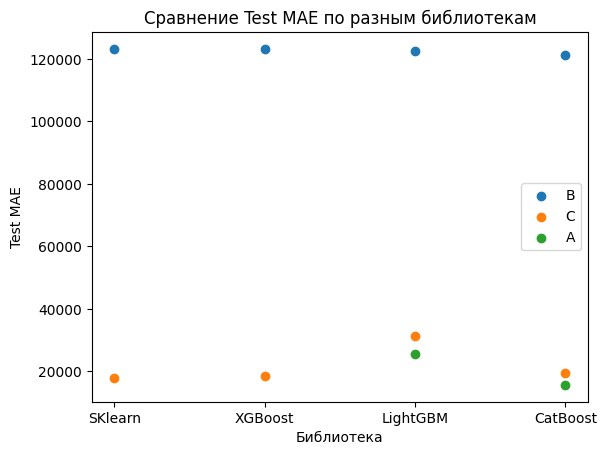

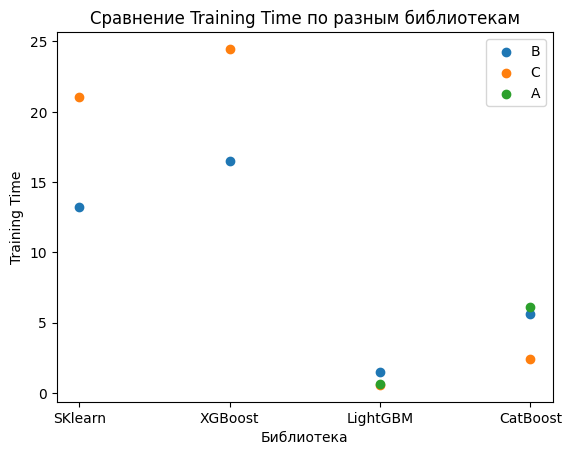

In [142]:
df_skl.iloc[[0]]

dfs = [df_skl, df_xgb, df_lightgbm, df_catboost]

plt.title('Сравнение Test MAE по разным библиотекам')
plt.xlabel('Библиотека')
plt.ylabel('Test MAE')
plt.scatter(['SKlearn', 'XGBoost', 'LightGBM', 'CatBoost'], [i[i['Dataset'] == 'B']['Test MAE'] for i in dfs], label='B')
plt.scatter(['SKlearn', 'XGBoost', 'LightGBM', 'CatBoost'], [i[i['Dataset'] == 'C']['Test MAE'] for i in dfs], label='C')
plt.scatter(['LightGBM', 'CatBoost'], [i[i['Dataset'] == 'A']['Test MAE'] for i in dfs[2:]], label='A')
plt.legend()
plt.show()


plt.title('Сравнение Training Time по разным библиотекам')
plt.xlabel('Библиотека')
plt.ylabel('Training Time')
plt.scatter(['SKlearn', 'XGBoost', 'LightGBM', 'CatBoost'], [i[i['Dataset'] == 'B']['Training time'] for i in dfs], label='B')
plt.scatter(['SKlearn', 'XGBoost', 'LightGBM', 'CatBoost'], [i[i['Dataset'] == 'C']['Training time'] for i in dfs], label='C')
plt.scatter(['LightGBM', 'CatBoost'], [i[i['Dataset'] == 'A']['Training time'] for i in dfs[2:]], label='A')
plt.legend()
plt.show()

**Ваши выводы:** По времени LightGBM работает быстрее всех, но по качеству может быть чуть хуже. Catboost лучший по качеству, хоть и дольше по времени. XGBoost и SKlearn сравнимы по качеству, но по времени проигрывают первым двум бойцам - библиотекам.

## Оптимизация параметров

И так, мы с вами научились пользоваться библиотеками для градиентного бустинга. Пришло время заняться самой интересной (нет) частью исследований, а именно подбором параметров!

Выберите любые две библиотеки из тех, с которыми мы работали в этом ноутбуке, и осуществите для них перебор параметров по сетке.

Обратите внимание, что:

1. Для всех библиотек вы можете воспользоваться классом GridSearchCV, реализованном в sklearn, осуществляющего кросс-валидацию всех параметров и поиска модели с лучшим качеством. Обратите внимание, что этот класс позволяет установить количество разбиений датасета, что достаточно сильно влияет на время работы. Также вы можете воспользоваться n_jobs=-1 для распараллеливания процесса перебора. ВНИМАНИЕ! Если Вы устанавливаете n_jobs для GridSearchCV, то не надо использовать этот параметр для обучаемых регрессоров! Результат может быть плачевным в плане времени...
2. В catboost существует своя реализация перебора параметров, которым можно также воспользоваться (речь о grid_search).
3. Для подбора правильной сетки параметров советуем обратиться к краткому руководству в начале ноутбука.


### Задание 7.1 (кросс-проверка, 2 балла):
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять две любые библиотеки градиентного бустинга (можете взять самые быстрые)
2. Составить сетку перебора параметров, включающую параметры n_estimators, max_depth и learning_rate.
3. Осуществите перебор параметров по вашей сетке при помощи GridSearchCV на датасетах B и C. Замерьте время перебора. Посчитайте качество модели обученной с оптимальными (с позиции кросс-валидации) параметрами на тренировочном и тестовом множествах.
4. Сделайте выводы о полезности перебора параметров.


## Внимание!

По какой-то причине, которую мне не удалось выяснить, catboost в google colab работает очень медленно при переборе параметров. Если в соответствующем задании время обучения catboost занимает не многим более 10 секунд, то в случае кросс-валидации оно возрастает до 5 минут (соответственно, 5 минут в каждом из узлов). Поэтому используйте catboost на свой страх и риск :)

In [162]:
df_optimized = pd.DataFrame(columns=['Library', 'Dataset', 'Training time', 'Train MAE', 'Test MAE'])

parameters = {'learning_rate' : [1e-2, 1e-1, 1],
              'max_depth' : [5, 6, 7],
              'n_estimators' : [500, 1000, 1500],
              }

In [163]:
model1 = LGBMRegressor()
grid1 = GridSearchCV(model1, parameters, n_jobs=-1, cv=3)

time1 = time.time()
grid1.fit(B_train, y_train)
time1 = time.time() - time1

model2 = LGBMRegressor()
grid2 = GridSearchCV(model2, parameters, n_jobs=-1, cv=3)

time2 = time.time()
grid2.fit(C_train, y_train)
time2 = time.time() - time2

In [155]:
model3 = GradientBoostingRegressor()
grid3 = GridSearchCV(model3, parameters, n_jobs=-1, cv=3)

time3 = time.time()
grid3.fit(B_train, y_train)
time3 = time.time() - time3

model4 = GradientBoostingRegressor()
grid4 = GridSearchCV(model4, parameters, n_jobs=-1, cv=3)

time4 = time.time()
grid4.fit(C_train, y_train)
time4 = time.time() - time4

In [164]:
print(time1)
print(time2)
print(time3)
print(time4)

print(mean_absolute_error(y_test, grid1.predict(B_test)))
print(mean_absolute_error(y_test, grid2.predict(C_test)))
print(mean_absolute_error(y_test, grid3.predict(B_test)))
print(mean_absolute_error(y_test, grid4.predict(C_test)))

63.484691858291626
69.78873324394226
246.95066022872925
414.01385021209717
126271.91513930126
41170.85005281638
122210.35444989905
25988.26925899516


**Ваши выводы:** Стало лучше качество на В за счёт перебора параметров. Но ушло много времени.

### Задание 7.2 (бонус) (кросс-проверка, 4 балла):
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Выполнить задание 7.1 с использованием всех библиотек (для каждой библиотеки можно использовать свою сетку перебора). Разрешается использовать маленькие сетки с небольшим числом узлов, но не менее 10.
1. Вывести ниже результаты работы с нашими дефолтными параметрами, а также с оптимальными.
1. Вы будете получать 1 балл за каждую библиотеку с использованием которой точность ваших оптимальных параметров превзойдет качество наших дефолтных параметров. Таким образом, максимальный балл за задание равен числу библиотек, 4 балла. 


In [2]:
# долго ждать! плохой бонус! верните бонус с мемами!!!

**Ваши пояснения для проверяющих (опционально):**

Обычнно перебор параметров и поиск по сетке это самая скучная часть работы, поскольку занимает много времени, но не гарантирует воспроизведение результата при небольшом изменении датасета, да и сетку надо переосмысливать при каждом обновлении.

Но сейчас мы поймём, что этого можно избежать, поскольку есть библиотека, которая всё сделает за нас!

Эмоции выполняющего в этот момент.png

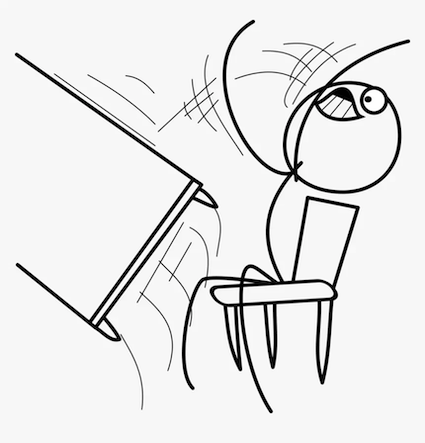

Нашего спасителя зовут HyperOpt. На первый взгляд hyperopt делает всё то же самое, что и grid search, а именно перебирает параметры. По факту же hyperopt превращает это в задачу оптимизации, используя некоторые эвристики для ускорения сходимости процесса. К тому же, он требует лишь информацию о границе интервалов, а не сами сетки. В теории это должно помочь нам добиться лучших результатов за более короткое время. Давайте попробуем это сделать.

Для данного эксперимента я рекомендую использовать lightgbm, поскольку она быстрее и с ней удобнее играться, но Вы можете воспользоваться любой библиотекой из представленных выше.

### Задание 8 (кросс-проверка, 2 балла):
**Данные**: датасет со стоимостью подержанных автомобилей

**Метрика**: MAE

**Цели**: В данном задании следует выполнить следующие пункты:
1. Взять любую библиотеку градиентного бустинга (можете взять самую быструю)
2. Составить сетку перебора в hyperopt, включающую параметры n_estimators, max_depth и learning_rate в hyperopt. Вам могут понадобиться такие типы данных, как hp.choise, hp.qloguniform, hp.uniform и hp.quniform (можно также пользоваться np.arange). Также для округления значения типа float до целых чисел (4.0 -> 4) используйте `scope.int`.
3. Реализуйте функцию, которая принимает на вход словарь параметров для регрессора, и при помощи cv оценивает его качество на датасете A (можно воспользоваться cross_val_score, а для ускорения поставить cv=3). Не забудьте о том, в каком виде lightgbm принимает категориальные признаки в numpy и что также надо передавать индексы категориальных признаков.
4. Создайте объект trials=Trials(), который будет хранить информацию о процессе оптимизации.
5. Используя функцию fmin, оптимизируйте Вашу функцию. Установите algo=tpe.suggest, trials=trials и max_evals, по крайней мере, 50. verbose=1 позволит видеть прогресс-бар по типу tqdm.
6. Выведите получившиеся параметры. Нарисуйте график, показывающий значение loss в ходе оптимизации. Посчитайте качество на тесте при использовании лучших параметров (возвращаются после использования fmin). Сделайте выводы по результату.

In [218]:
df['price']

0         34099.0
1         34099.0
2         41250.0
3         44930.0
4         57787.0
          ...    
5662    1300000.0
5663    1600000.0
5664    1950000.0
5665    1850000.0
5667    9600000.0
Name: price, Length: 4560, dtype: float64

In [252]:
from math import log

features = []
def f(param):
    model = LGBMRegressor(**param, random_state=0)
    print(param)
    scores = cross_val_score(model, datasets['A'], df['price'], cv=3, scoring='neg_mean_absolute_error')
    score = scores.mean()
    features.append(param)
    return -score

trials = Trials()

space = {
            'n_estimators' : hp.choice('n_estimators', np.arange(500, 1500, 100)),
            'max_depth' : hp.choice('max_depth', np.arange(5, 10, 1)),
            'learning_rate' : hp.loguniform('learning_rate', log(1e-4), log(2.7))
        }

best = fmin(f,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    verbose=1)

{'learning_rate': 0.032687435778168177, 'max_depth': 5, 'n_estimators': 700}
{'learning_rate': 0.05995575649323461, 'max_depth': 8, 'n_estimators': 1300}
{'learning_rate': 0.0032340573333381676, 'max_depth': 9, 'n_estimators': 1300}
{'learning_rate': 0.00043836933466073703, 'max_depth': 7, 'n_estimators': 700}
{'learning_rate': 0.009777972577005734, 'max_depth': 7, 'n_estimators': 1000}
{'learning_rate': 1.143366140740275, 'max_depth': 6, 'n_estimators': 1200}
{'learning_rate': 0.00045288947658113745, 'max_depth': 7, 'n_estimators': 500}
{'learning_rate': 0.026167298705973428, 'max_depth': 9, 'n_estimators': 1100}
{'learning_rate': 0.7281792110605999, 'max_depth': 5, 'n_estimators': 1100}
{'learning_rate': 0.006027933053155193, 'max_depth': 7, 'n_estimators': 1400}
{'learning_rate': 0.046582463187748, 'max_depth': 8, 'n_estimators': 1000}
{'learning_rate': 0.0017763209909602382, 'max_depth': 8, 'n_estimators': 1100}
{'learning_rate': 0.006568962360870217, 'max_depth': 8, 'n_estimators'

In [255]:
# Стандартные параметры
param = {'n_estimators' : 1000, 'max_depth' : 5, 'learning_rate' : 0.1}
m = LGBMRegressor(**param, random_state=0)
-cross_val_score(m, datasets['A'], df['price'], cv=3, scoring='neg_mean_absolute_error').mean()

149059.22192144263

In [257]:
# Наилучшие параметры
l = trials.losses()
print(min(l))
print(features[l.index(min(l))])

136868.88073234825
{'learning_rate': 0.006568962360870217, 'max_depth': 8, 'n_estimators': 1100}


Text(0.5, 1.0, 'Поведение MAE при оптимизации гиперпараметров')

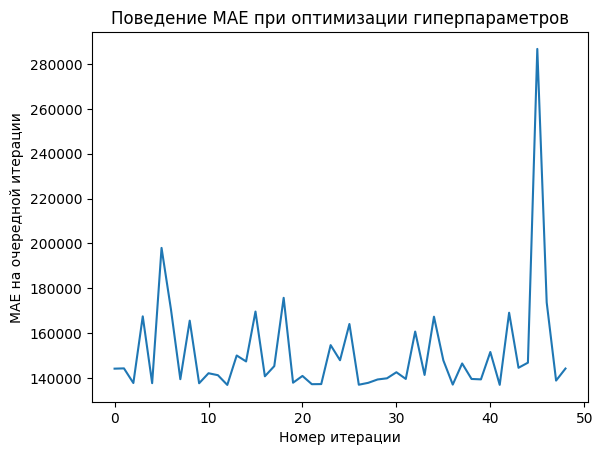

In [260]:
k = np.array(trials.losses())
plt.plot(k[k < 5e5])
plt.xlabel('Номер итерации')
plt.ylabel('MAE на очередной итерации')
plt.title('Поведение MAE при оптимизации гиперпараметров')

**Ваши выводы:** hyperopt способен оптимизировать гиперпараметры и получать результат лучше, чем было изначально.


## Конец

Ну что детишки... Можете добавлять еще 4 библиотеки в своё резюме датасаентиста!


```
(╯°□°)╯︵ ┻━┻ FLIP THAT TABLE.

┻━┻ ︵ ヽ(°□°ヽ) FLIP THIS TABLE.

┻━┻ ︵ ＼\('0')/／ ︵ ┻━┻ FLIP ALL THE TABLES

ಠ_ಠ Son... ಠ_ಠ Put. ಠ__ಠ The tables. ಠ___ಠ Back.

(╮°-°)╮┳━┳ 

(╯°□°)╯︵ ┻━┻ NEVER!!!!
```

